In [1]:
# # Install specific libraries
# ! pip install transformers
# ! pip install pycaret

# Imports

In [6]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import re
# specify GPU
device = torch.device("cuda")

In [7]:
# Set Working Directory - if working on Local Machine
import os
os.chdir('D:\FYP\Datasets for the project')

In [8]:
data = pd.read_csv("twitter_racism_parsed_dataset.csv")

# See how the data looks like
print(data.shape)
data.head()

(13471, 5)


,index,id,Text,Annotation,oh_label
0,5.770000e+17,5.770000e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.410000e+17,5.410000e+17,#NULL!,none,0
2,5.680000e+17,5.680000e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,5.770000e+17,5.770000e+17,"Finally I'm all caught up, and that sudden dea...",none,0
4,5.710000e+17,5.710000e+17,@carolinesinders @herecomesfran *hugs*,none,0


# Preprocess

In [9]:
tweet = "@AAlwuhaib1977 Stats for the day have arrived. 1 new follower and NO unfollowers :) via #Abc #dV xyzk http://t.co/0s8GQYOeus. #Fgh #wsd HHpp"
print('Original Tweet: ')
print(tweet)

################################################################################

def preprocess(tweet):
  # Remove the old style retweet text "RT"
  tweet2 = re.sub(r'^RT[\s]+', '', tweet)

  # Remove hyperlinks by matching URLs and replacing them with an empty string
  tweet2 = re.sub(r'http[s]?://\S+', '', tweet2)

  # Remove hashtags. We have to be careful here not to remove
  # the whole hashtag because the text of hashtags contains valuable information.
  # Only removing the hash # sign from the word
  tweet2 = re.sub(r'#', '', tweet2) # TODO: Tokenize hashtags and see if sentiment analysis improves

  # Remove user mentions
  tweet2 = re.sub(r'@[A-Za-z0-9]+', '', tweet2)

  # Convert all words to lowercase
  tweet2 = tweet2.lower()

  return tweet2

################################################################################

print('\nAfter:')
tweet2 = preprocess(tweet)
print(tweet2)

Original Tweet: 
@AAlwuhaib1977 Stats for the day have arrived. 1 new follower and NO unfollowers :) via #Abc #dV xyzk http://t.co/0s8GQYOeus. #Fgh #wsd HHpp

After:
 stats for the day have arrived. 1 new follower and no unfollowers :) via abc dv xyzk  fgh wsd hhpp


In [10]:
data["preprocessed_text"] = data.Text.apply(preprocess)

In [11]:
print(data.shape)
data.oh_label.value_counts()

(13471, 6)


0    11501
1     1970
Name: oh_label, dtype: int64

In [12]:
1970/13471

0.14624007126419716

([<matplotlib.patches.Wedge at 0x13bde513700>,
 [Text(-0.5321212259370308, 1.0755682223398346, 'Racism'),
  Text(0.5321212762880129, -1.0755681974294409, 'none')],
 [Text(-0.3104040484632679, 0.6274147963649034, '14.6%'),
  Text(0.3104040778346741, -0.6274147818338404, '85.4%')])

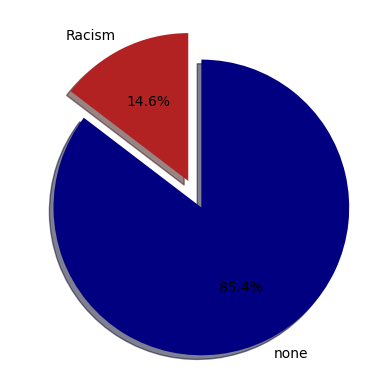

In [13]:
# Checking if our data is well balanced
label_size = [data['oh_label'].sum(),len(data['oh_label'])-data['oh_label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Racism','none'],autopct='%1.1f%%')

# Data splitting

In [14]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['preprocessed_text'], data['oh_label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['oh_label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [15]:
print(train_text.shape)
print(val_text.shape)
print(test_text.shape)

(9429,)
(2021,)
(2021,)


In [16]:
train_text.head()

1060    we seek to help clarify those policies and gai...
4974         _shami2 notice how there are no girls? and: 
7836    oh, look. here's nero and wadhwa colluding, to...
2840    _tim84: cravings met 👍 mkr mykitchenrules mast...
5586                      prove it. where is the proof???
Name: preprocessed_text, dtype: object

# BERT fine-tuning

In [17]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'Number of texts')

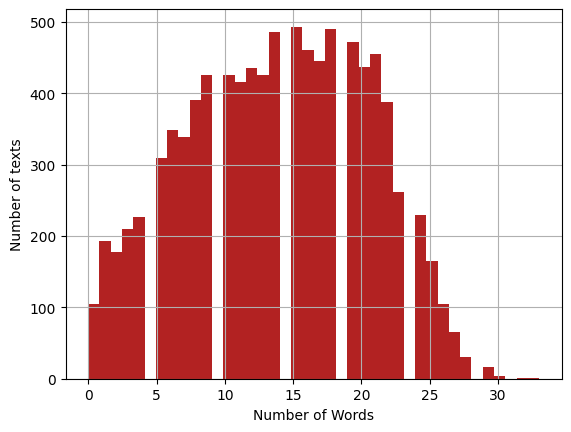

In [18]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [19]:
# BERT Tokeizer Functionality
sample_data = ["Build racism detection model."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)
print(tokenizer.convert_ids_to_tokens(tokenized_sample_data['input_ids'][0]))          # decode text

# Ref: https://huggingface.co/docs/transformers/preprocessing

{'input_ids': [[101, 3857, 14398, 10788, 2944, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}
['[CLS]', 'build', 'racism', 'detection', 'model', '.', '[SEP]']


In [20]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 26
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [21]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [22]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [23]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [24]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

# Training

In [25]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [26]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_finetuning_on_racism_model.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    295.
  Batch   100  of    295.
  Batch   150  of    295.
  Batch   200  of    295.
  Batch   250  of    295.

Evaluating...
  Batch    50  of     64.

Training Loss: 0.416
Validation Loss: 0.344

 Epoch 2 / 2
  Batch    50  of    295.
  Batch   100  of    295.
  Batch   150  of    295.
  Batch   200  of    295.
  Batch   250  of    295.

Evaluating...
  Batch    50  of     64.

Training Loss: 0.338
Validation Loss: 0.313


In [27]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1726
           1       0.77      0.18      0.29       295

    accuracy                           0.87      2021
   macro avg       0.82      0.59      0.61      2021
weighted avg       0.86      0.87      0.84      2021



In [ ]:
# # testing on unseen data
# unseen_text = ["Black men are taught that a word justifies all forms of violence against white people.",     # Racism
#                     "Northern California Declares Independence From China. Ã¢Â€ÂœThe State of JeffersonÃ¢Â€Â Declares RESTORATION must take place to save our nation. Enter the armed patriots. State Right.",               # Fake
#                     "Black Chairman of Proud Boys Speaks Out after Liars Joe Biden and Chris Wallace Call Them White Supremacists",           # Racism
#                     "Trump administration issues new rules on U.S. visa waivers"                          # Normal
#                     ]

# # tokenize and encode sequences in the test set
# MAX_LENGHT = 15
# tokens_unseen = tokenizer.batch_encode_plus(
#     unseen_text,
#     max_length = MAX_LENGHT,
#     pad_to_max_length=True,
#     truncation=True
# )

# unseen_seq = torch.tensor(tokens_unseen['input_ids'])
# unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

# with torch.no_grad():
#   preds = model(unseen_seq, unseen_mask)
#   preds = preds.detach().cpu().numpy()

# preds = np.argmax(preds, axis = 1)
# preds

array([0, 0, 0, 0], dtype=int64)

# Training on another dataset (HateXplain)

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import re
# specify GPU
device = torch.device("cuda")

# Set Working Directory - if working on Local Machine
import os
os.chdir('D:\FYP\Datasets for the project')

In [ ]:
import pandas as pd

data2 = pd.read_csv("hatexplain.csv")

# See how the data looks like
print(data2.shape)
data2.head()

(20148, 6)


,Unnamed: 0.1,Unnamed: 0,label,target,tokens,text
0,0,1179055004553900032_twitter,normal,None,"['i', 'dont', 'think', 'im', 'getting', 'my', ...",i dont think im getting my baby them white 9 h...
1,1,1179063826874032128_twitter,normal,None,"['we', 'cannot', 'continue', 'calling', 'ourse...",we cannot continue calling ourselves feminists...
2,2,1178793830532956161_twitter,normal,African,"['nawt', 'yall', 'niggers', 'ignoring', 'me']",nawt yall niggers ignoring me
3,3,1179088797964763136_twitter,hatespeech,Asian,"['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",<user> i am bit confused coz chinese ppl can n...
4,4,1179085312976445440_twitter,hatespeech,Caucasian,"['this', 'bitch', 'in', 'whataburger', 'eating...",this bitch in whataburger eating a burger with...


In [ ]:
# Define a mapping dictionary
# label_mapping = {'normal': 0, 'offensive': 1, 'hatespeech': 2}
label_mapping = {'normal': 0, 'offensive': 1, 'hatespeech': 1} # NOTE: 1 for BOTH offensive and hatespeech (Going with binary classification)

# Use the map function to assign numerical values based on label names
data2['numeric_label'] = data2['label'].map(label_mapping)

In [ ]:
data2.head()

,Unnamed: 0.1,Unnamed: 0,label,target,tokens,text,numeric_label
0,0,1179055004553900032_twitter,normal,None,"['i', 'dont', 'think', 'im', 'getting', 'my', ...",i dont think im getting my baby them white 9 h...,0
1,1,1179063826874032128_twitter,normal,None,"['we', 'cannot', 'continue', 'calling', 'ourse...",we cannot continue calling ourselves feminists...,0
2,2,1178793830532956161_twitter,normal,African,"['nawt', 'yall', 'niggers', 'ignoring', 'me']",nawt yall niggers ignoring me,0
3,3,1179088797964763136_twitter,hatespeech,Asian,"['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",<user> i am bit confused coz chinese ppl can n...,1
4,4,1179085312976445440_twitter,hatespeech,Caucasian,"['this', 'bitch', 'in', 'whataburger', 'eating...",this bitch in whataburger eating a burger with...,1


In [ ]:
data2.numeric_label.value_counts()

1    11995
0     8153
Name: numeric_label, dtype: int64

In [ ]:
data2.head()

,Unnamed: 0.1,Unnamed: 0,label,target,tokens,text,numeric_label
0,0,1179055004553900032_twitter,normal,None,"['i', 'dont', 'think', 'im', 'getting', 'my', ...",i dont think im getting my baby them white 9 h...,0
1,1,1179063826874032128_twitter,normal,None,"['we', 'cannot', 'continue', 'calling', 'ourse...",we cannot continue calling ourselves feminists...,0
2,2,1178793830532956161_twitter,normal,African,"['nawt', 'yall', 'niggers', 'ignoring', 'me']",nawt yall niggers ignoring me,0
3,3,1179088797964763136_twitter,hatespeech,Asian,"['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",<user> i am bit confused coz chinese ppl can n...,1
4,4,1179085312976445440_twitter,hatespeech,Caucasian,"['this', 'bitch', 'in', 'whataburger', 'eating...",this bitch in whataburger eating a burger with...,1


In [ ]:
data2 = data2[['text', 'numeric_label']] # Selecting only the required columns

In [ ]:
data2.head()

,text,numeric_label
0,i dont think im getting my baby them white 9 h...,0
1,we cannot continue calling ourselves feminists...,0
2,nawt yall niggers ignoring me,0
3,<user> i am bit confused coz chinese ppl can n...,1
4,this bitch in whataburger eating a burger with...,1


In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data2['text'], data2['numeric_label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data2['numeric_label'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
print(train_text.shape)
print(val_text.shape)
print(test_text.shape)

(14103,)
(3022,)
(3023,)


In [ ]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0, 0.5, 'Number of texts')

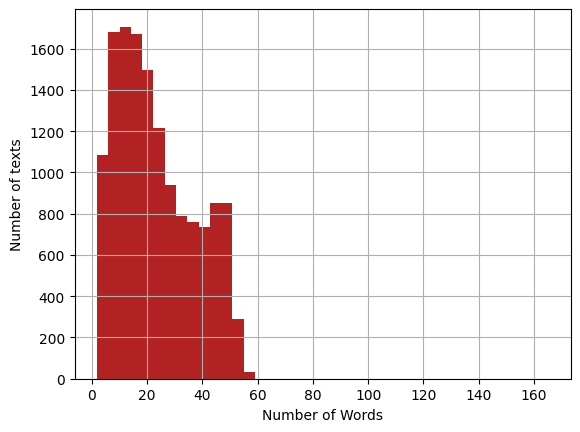

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(text.split()) for text in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 60
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [ ]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'BERT_finetuning_on_hateXplain_model.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    441.
  Batch   100  of    441.
  Batch   150  of    441.
  Batch   200  of    441.
  Batch   250  of    441.
  Batch   300  of    441.
  Batch   350  of    441.
  Batch   400  of    441.

Evaluating...
  Batch    50  of     95.

Training Loss: 0.662
Validation Loss: 0.659

 Epoch 2 / 2
  Batch    50  of    441.
  Batch   100  of    441.
  Batch   150  of    441.
  Batch   200  of    441.
  Batch   250  of    441.
  Batch   300  of    441.
  Batch   350  of    441.
  Batch   400  of    441.

Evaluating...
  Batch    50  of     95.

Training Loss: 0.656
Validation Loss: 0.650


In [ ]:
# load weights of best model
path = 'BERT_finetuning_on_hateXplain_model.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.68      0.08      0.14      1223
           1       0.61      0.97      0.75      1800

    accuracy                           0.61      3023
   macro avg       0.64      0.53      0.45      3023
weighted avg       0.64      0.61      0.50      3023



In [ ]:
# testing on unseen data
unseen_text = ["i dont think im getting my baby them white 9 he has two white j and nikes not even touched",
"nawt yall niggers ignoring me"]

# tokenize and encode sequences in the test set
# MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1], dtype=int64)